# Create ACS Index and Azure SQL Database for Avatar Demo
Use this notebook to create an Azure Cognitive Search Index and an Azure SQL Database and populate demo content for the Avatar outdoor shop application.  

Ensure that you have the the Microsoft ODBC driver for SQL Server installed. Here are the instructions for Linux based systems:  
https://learn.microsoft.com/en-us/sql/connect/odbc/linux-mac/installing-the-microsoft-odbc-driver-for-sql-server?view=sql-server-ver16&tabs=ubuntu18-install%2Calpine17-install%2Cdebian8-install%2Credhat7-13-install%2Crhel7-offline#18


## Setup

In [3]:
# Install the required libraries
%pip install azure-search-documents==11.4.0b6 openai==0.28.1 tenacity pyodbc

# Install library for Azure Authentication
%pip install azure-identity azure-storage-blob

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import json  
import pandas as pd

import pyodbc
import requests
import inspect

import openai  
from tenacity import retry, wait_random_exponential, stop_after_attempt  
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import Vector  
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,  
    SearchIndex,  
    SemanticConfiguration,  
    PrioritizedFields,  
    SemanticField,  
    SearchField,  
    SemanticSettings,  
    VectorSearch,  
    VectorSearchAlgorithmConfiguration,  
)  

You need to have the following settings for your Azure resources defined in the `local.settings.json` file in the __api__ subfolder to populate the demo content for the outdoor app:

In [10]:
#%pwd
#!cd c:/users/chihengchou/downloads/work/work/gen-cv-forked/gen-cv/avatar/interactive
%cd c:\\Users\\chihengchou\\Downloads\\work\\work\\gen-cv-forked - gov\\gen-cv\\avatar\\interactive
%pwd

c:\Users\chihengchou\Downloads\work\work\gen-cv-forked - gov\gen-cv\avatar\interactive


'c:\\Users\\chihengchou\\Downloads\\work\\work\\gen-cv-forked - gov\\gen-cv\\avatar\\interactive'

In [18]:
# Load JSON file
with open('./api/local.settings.json', 'r') as file:
    data = json.load(file)

# Azure Cognitive Search
service_endpoint = data["Values"]["AZURE_SEARCH_ENDPOINT"]
key = data["Values"]["AZURE_SEARCH_API_KEY"]
index_name = data["Values"]["AZURE_SEARCH_INDEX"]

# Blob SAS URL for Azure Storage Account
blob_sas_url = data["Values"]["BLOB_SAS_URL"]
blob_container_name = data["Values"]["BLOB_CONTAINER_NAME"]
use_entra_id = data["Values"]["USE_ENTRA_ID"]

# Azure OpenAI
openai.api_type = "azure"
openai.api_key = data["Values"]["AZURE_OPENAI_API_KEY"]
openai.api_base = data["Values"]["AZURE_OPENAI_ENDPOINT"]
openai.api_version = data["Values"]["AZURE_OPENAI_API_VERSION"]
AOAI_embeddings_deployment = data["Values"]["AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT"]

# Azure SQL Database
sql_db_server = data["Values"]["SQL_DB_SERVER"]
sql_db_user = data["Values"]["SQL_DB_USER"]
sql_db_password = data["Values"]["SQL_DB_PASSWORD"]
sql_db_name = data["Values"]["SQL_DB_NAME"]

In [11]:
# Only used for Microsoft Entra ID authentication testing
# Need to run az login first in terminal in VS Code

# from azure.identity import DefaultAzureCredential
# from azure.storage.blob import BlobServiceClient

# account_url = "https://aoaipaytonstr.blob.core.windows.net"
# default_credential = DefaultAzureCredential()

# # Create the BlobServiceClient object
# blob_service_client = BlobServiceClient(account_url, credential=default_credential)

# # Test Connection
# print("\nPrint service properties...")
# service_properties = blob_service_client.get_service_properties()
# for service_property in service_properties:
#     print(service_property)


Print service properties...
analytics_logging
hour_metrics
minute_metrics
cors
target_version
delete_retention_policy
static_website


In [67]:
# Test to get image url

# from azure.identity import DefaultAzureCredential
# from azure.storage.blob import BlobServiceClient
# import requests

# # 設置你的 Azure Blob Storage 資訊
# account_url = "https://aoaipaytonstr.blob.core.windows.net"
# container_name = "gov-images"

# # 使用 DefaultAzureCredential 進行身份驗證
# credential = DefaultAzureCredential()
# blob_service_client = BlobServiceClient(account_url=account_url, credential=credential)

# def get_image_url(product_info):
#     image_file = product_info['product_image_file']

#     # 生成圖像 URL
#     blob_client = blob_service_client.get_blob_client(container=container_name, blob=image_file)
#     image_url = blob_client.url

#     response = requests.get(image_url)
#     print(image_url)

# # 示例使用
# product_info = {'product_image_file': '1.png'}
# get_image_url(product_info)

https://aoaipaytonstr.blob.core.windows.net/gov-images/1.png


## Create Cognitive Search Index
First, we create a new Index with demo data to the Cognitive Search service that you have deployed manually.

In [47]:
credential = AzureKeyCredential(key)

# csv原始資料需要去掉/n
df = pd.read_csv('data/products_cs_index.csv', dtype={'id': str})

# display(df.head())
display(df.tail())
input_data = df.to_dict(orient='records')

,id,content,product_image_file
0,1,'## 政府在AI人才培育中的策略 ### 國發會提出五大策略充裕AI產業人才 國發會針對A...,1.png
1,2,'## 數位國家．創新經濟發展方案包含哪些內容？ ### 「數位國家．創新經濟發展方案(20...,2.png


In [48]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
# Function to generate embeddings for title and content fields, also used for query embeddings
def generate_embeddings(text):
    response = openai.Embedding.create(
        input=text, engine=AOAI_embeddings_deployment)
    embeddings = response['data'][0]['embedding']
    return embeddings

In [49]:
# Generate embeddings for title and content fields
for item in input_data:
    content = item['content']
    content_embeddings = generate_embeddings(content)
    item['content_vector'] = content_embeddings

In [50]:
# Output embeddings to docVectors.json file
with open("./data/product-catalog-vectors.json", "w") as f:
    json.dump(input_data, f)

In [51]:
# Delete ACS index if it exists
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

try:
    if index_client.get_index(index_name):
        print('Deleting existing index...')
        index_client.delete_index(index_name)

except:
    print('Index does not exist. No need to delete it.')

Deleting existing index...


In [52]:
# Create a search index
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="content", type=SearchFieldDataType.String),
    SearchField(name="content_vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                 searchable=True, vector_search_dimensions=1536, vector_search_configuration="my-vector-config"),
    SimpleField(name="product_image_file", type=SearchFieldDataType.String),
]

vector_search = VectorSearch(
    algorithm_configurations=[
        VectorSearchAlgorithmConfiguration(
            name="my-vector-config",
            kind="hnsw",
            hnsw_parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 500,
                "metric": "cosine"
            }
        )
    ]
)

index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')

 gov created


In [53]:
# Upload documents to the index
with open("./data/product-catalog-vectors.json", 'r') as file:  
    documents = json.load(file)  
search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)
result = search_client.upload_documents(documents)  
print(f"Uploaded {len(documents)} documents") 

Uploaded 2 documents


## Perform Test Queries
We are performing a few test queries against the Cognitive Search index. If successful, it should display outdoor product information and images.

In [62]:
search_client = SearchClient(service_endpoint, index_name, credential=credential)  
fields_of_interest = ["id", "content", "product_image_file"]

Results:
<iterator object azure.core.paging.ItemPaged at 0x1bd017be710>
ID: 1
Score: 0.93142134
Content: '## 政府在AI人才培育中的策略 ### 國發會提出五大策略充裕AI產業人才 國發會針對AI人才短缺提出五大策略，包括：鼓勵企業自訓並強化跨域人才的培養、協助企業規劃人才布局、訂立AI國際頂尖人才標準並開展全球獵才行動、持續檢討和放寬攬才法規以提高攬才競爭力、以及為AI人才來台提供誘因，建立吸引人的留才生態系。這些策略將協助台灣在全球AI競賽中取得優勢。'
Image file: 1.png

Image URL: https://aoaipaytonstr.blob.core.windows.net/gov-images/1.png


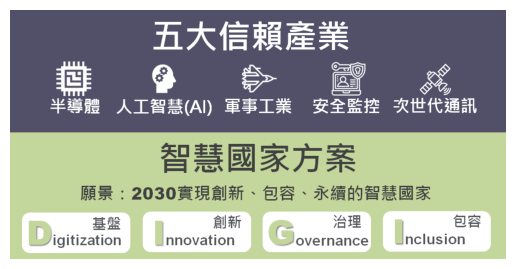

ID: 2
Score: 0.84561795
Content: '## 數位國家．創新經濟發展方案包含哪些內容？ ### 「數位國家．創新經濟發展方案(2017-2025年)」（簡稱DIGI⁺方案） DIGI⁺方案現已完成第一階段(2017-2020年)預定之推動任務，因應未來智慧國家發展願景，將更名升級為「智慧國家方案(2021-2025年)」（簡稱本方案）。該方案將納入臺灣資安卓越深耕、Beyond 5G衛星通訊、Å世代半導體、雲世代產業數位轉型及先進網路建設等前瞻數位科技，並配合已核定之「前瞻基礎建設之數位建設」、「臺灣AI行動計畫」、「資安產業發展行動計畫」、「臺灣5G行動計畫」、「臺灣顯示科技與應用行動計畫」、「台灣運動x科技行動計畫」、「臺灣AI行動計畫2.0」等跨部會合作之重大數位政策。'
Image file: 2.png

Image URL: https://aoaipaytonstr.blob.core.windows.net/gov-images/2.png


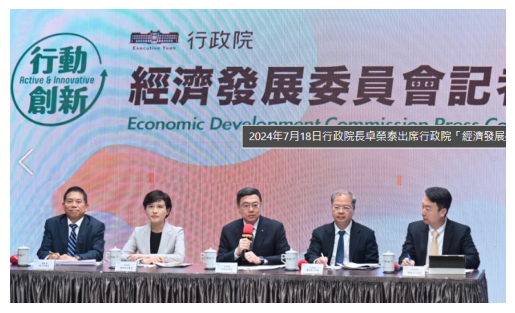

In [66]:
# Test code for using BlobServiceClient
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
import matplotlib.pyplot as plt
from io import BytesIO
import requests

def display_image_from_blob(image_file):
    if use_entra_id:
        try:
            # Test for Microsoft Entra ID authentication
            account_url = f"https://{blob_container_name}.blob.core.windows.net"
            default_credential = DefaultAzureCredential()
    
            # Create the BlobServiceClient object
            blob_service_client = BlobServiceClient(account_url, credential=default_credential)
    
            # Get the blob client
            blob_client = blob_service_client.get_blob_client(container="gov-images", blob=image_file)

            # 獲取圖像的 URL
            image_url = blob_client.url
            # 打印圖像 URL
            print(f"Image URL: {image_url}")

            # Download the blob content
            blob_data = blob_client.download_blob().readall()
            
            # Open the image and display it
            img = plt.imread(BytesIO(blob_data))
            plt.imshow(img)
            plt.axis('off')  # No axes for this plot
            plt.show()
        except Exception as e:
            print(f"Failed to retrieve image. Error: {e}")
    else:
        # Append the image name to the SAS URL
        image_url = blob_sas_url.split("?")[0] + f"/{image_file}?" + blob_sas_url.split("?")[1]
    
        # Get the image content
        response = requests.get(image_url)
    
        # Check if the request was successful
        if response.status_code == 200:
            # Open the image and display it
            img = plt.imread(BytesIO(response.content))
            plt.imshow(img)
            plt.axis('off') # No axes for this plot
            plt.show()
        else:
            print(f"Failed to retrieve image. HTTP Status code: {response.status_code}")

def print_results(results):
  print("Results:")
  print(results)
  for result in results:
    print(f"ID: {result['id']}")
    print(f"Score: {result['@search.score']}")
    print(f"Content: {result['content']}")  
    print(f"Image file: {result['product_image_file']}\n")
    display_image_from_blob(result['product_image_file'])

# Pure Vector Search
query = "請問政府在AI人才培育中的策略？"

results = search_client.search(  
    search_text=None,  
    vector=generate_embeddings(query), top_k=3,  
    vector_fields="content_vector",
    select= fields_of_interest
)  
print_results(results)